<h1>Importing Packages and Dataframe<h1>

In [1]:
import ssl
import pandas as pd
import missingno as msno
import folium
import geopandas as gpd
import haversine as hs
import statistics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

df.info()

#The following columns are being dropped
# DATA SOURCE
# 2   scrape_id                                     7389 non-null   int64  
# 3   last_scraped                                  7389 non-null   object 
# 4   source                                        7389 non-null   object 
# 55  calendar_last_scraped                         7389 non-null   object 

# DROP
# 35  bathrooms                                     0 non-null      float64
# 49  calendar_updated                              0 non-null      float64
# 68  license                                       15 non-null     object 
# 59  first_review                                  6724 non-null   object 
# 60  last_review                                   6724 non-null   object 
# 14  host_about                                    4292 non-null   object



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7389 non-null   int64  
 1   listing_url                                   7389 non-null   object 
 2   scrape_id                                     7389 non-null   int64  
 3   last_scraped                                  7389 non-null   object 
 4   source                                        7389 non-null   object 
 5   name                                          7389 non-null   object 
 6   description                                   7318 non-null   object 
 7   neighborhood_overview                         5184 non-null   object 
 8   picture_url                                   7389 non-null   object 
 9   host_id                                       7389 non-null   i

<h1>Cleaning the Data<h1>

In [2]:
dfDropped = df.drop(['scrape_id', 'picture_url','last_scraped', 'source', 'calendar_last_scraped', 'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license', 'first_review', 'last_review', 'host_neighbourhood','neighbourhood','neighborhood_overview','host_about'], axis=1)

dfDropped = dfDropped[['id','name','description','listing_url','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','latitude','longitude','host_id','host_url','host_name','host_since','host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','neighbourhood_cleansed','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','availability_30','availability_60','availability_90','availability_365','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month','instant_bookable']]                             

# PRICES
priceDF = dfDropped['price']
prices=[]

for p in priceDF:
    p = float(p[1:].replace(',',''))
    prices.append(p)

dfDropped['price'] = prices

dfDropped = dfDropped[dfDropped.bedrooms > 0]
dfDropped = dfDropped[dfDropped.accommodates > 0]
dfDropped = dfDropped[dfDropped.price > 0]
dfDropped = dfDropped[dfDropped.beds > 0]

# BATHROOMS
df['bathrooms_ text'] = df['bathrooms_text'].astype(str)
dfDropped.bathrooms_text.str.extract(r'([\d.])').astype(float)
display(dfDropped.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181 entries, 0 to 7388
Data columns (total 60 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7181 non-null   int64  
 1   name                                          7181 non-null   object 
 2   description                                   7121 non-null   object 
 3   listing_url                                   7181 non-null   object 
 4   property_type                                 7181 non-null   object 
 5   room_type                                     7181 non-null   object 
 6   accommodates                                  7181 non-null   int64  
 7   bathrooms_text                                7171 non-null   object 
 8   bedrooms                                      7181 non-null   float64
 9   beds                                          7181 non-null   f

None

In [3]:
dfDropped.dropna(inplace=True)
low = 0.025
high = 0.975
dfDropped1 = dfDropped.quantile([low, high])

low = dfDropped1['price'][0.025]
high = dfDropped1['price'][0.975]

dfDropped = dfDropped[dfDropped['price']>=low]
dfDropped = dfDropped[dfDropped['price']<=high]

/var/folders/24/ng3jyr1s1xl2yrxrpzkc9tl80000gn/T/ipykernel_41959/368344838.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfDropped1 = dfDropped.quantile([low, high])


<h1>Displaying Price Per Night In Edinbrugh<h1>

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 111 entries, 0 to 110
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   neighbourhood  111 non-null    object  
 1   geometry       111 non-null    geometry
 2   price          109 non-null    float64 
dtypes: float64(1), geometry(1), object(1)
memory usage: 3.5+ KB


Text(61.472222222222214, 0.5, 'Latitude')

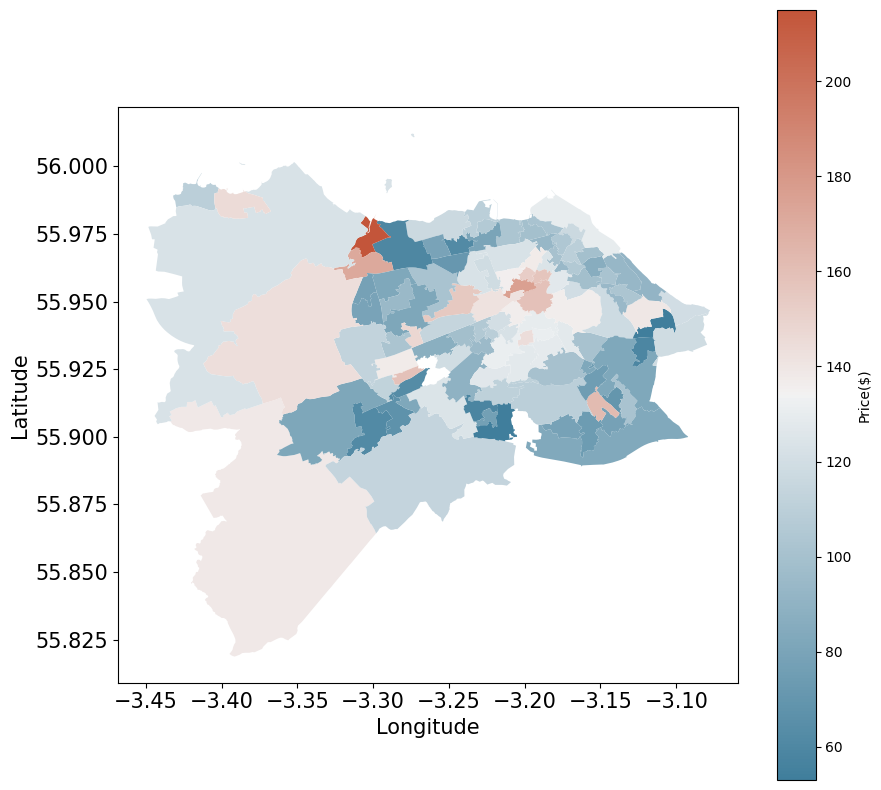

In [4]:
priceDf = dfDropped.copy(True)
priceDf = priceDf.rename({"neighbourhood_cleansed":"neighbourhood"}, axis = 'columns')

#neighbourhoodson is dataframe holding geo data 
neighbourhoodson = gpd.read_file('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/neighbourhoods.geojson')
priceDf = priceDf.groupby('neighbourhood')['price'].mean().round(2).reset_index()
priceDf = neighbourhoodson.merge(priceDf, on = 'neighbourhood', how = 'left')
priceDf = priceDf.drop(['neighbourhood_group'], axis=1)
priceDf.info()

cmap = sns.diverging_palette(230, 20, as_cmap=True)

#plotting graph
ax = priceDf.plot(column='price', legend=True, figsize=(10, 10), cmap = cmap, legend_kwds = {"label": "Price($)"})

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

#adding x and y labels
plt.xlabel("Longitude", fontsize = 15)
plt.ylabel("Latitude" , fontsize = 15)



In [5]:
priceDf = priceDf.sort_values(by=['price'])
display(priceDf)

,neighbourhood,geometry,price
23,Comiston and Swanston,"MULTIPOLYGON (((-3.21032 55.91261, -3.21020 55...",53.00
53,"Bingham, Magdalene and The Christians","MULTIPOLYGON (((-3.10194 55.94432, -3.10089 55...",53.33
21,Colinton Mains and Firrhill,"MULTIPOLYGON (((-3.23759 55.91571, -3.23718 55...",58.20
52,Niddrie,"MULTIPOLYGON (((-3.11475 55.93601, -3.11466 55...",58.88
96,Siverknowes and Davidson's Mains,"MULTIPOLYGON (((-3.27669 55.98025, -3.27664 55...",59.60
...,...,...,...
98,"Barnton, Cammo and Cramond South","MULTIPOLYGON (((-3.30916 55.96957, -3.30915 55...",171.50
80,New Town West,"MULTIPOLYGON (((-3.20698 55.95869, -3.20702 55...",176.26
97,Cramond,"MULTIPOLYGON (((-3.29933 55.98077, -3.29927 55...",215.00
12,Longstone and Saughton,"MULTIPOLYGON (((-3.26184 55.93028, -3.26178 55...",NaN


In [6]:
cramondDF = dfDropped.copy(True)
cramondDF = cramondDF[cramondDF['neighbourhood_cleansed'] == 'Cramond']
display(cramondDF)

,id,name,description,listing_url,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,...,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable
2445,26031827,Quay Cottage,A delightful self catering holiday cottage loc...,https://www.airbnb.com/rooms/26031827,Entire home,Entire home/apt,4,1 bath,2.0,3.0,...,0,4.77,4.84,4.81,4.77,4.63,4.91,4.65,0.82,f
2890,30819810,Almond View (UK5046),A unique whitewashed 2 bedroomed B listed prop...,https://www.airbnb.com/rooms/30819810,Entire home,Entire home/apt,4,1 bath,2.0,3.0,...,1,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.07,t
2892,30854247,Sailor's Cottage (30229),"Ideally located for a beach, sightseeing or ci...",https://www.airbnb.com/rooms/30854247,Entire home,Entire home/apt,6,2 baths,3.0,4.0,...,1,4.83,4.67,4.50,5.00,4.83,5.00,4.67,0.46,t
2896,30884560,Cobble Cottage (28388),A cosy pet friendly property for a small famil...,https://www.airbnb.com/rooms/30884560,Entire home,Entire home/apt,3,1 bath,2.0,2.0,...,0,5.00,4.67,5.00,3.67,4.33,5.00,5.00,0.39,t
4646,50947520,One bedroom flat on third floor of the block .,A bright one bed flat in picturesque Cramond....,https://www.airbnb.com/rooms/50947520,Entire condo,Entire home/apt,2,1 bath,1.0,1.0,...,0,4.95,4.95,4.85,4.95,5.00,4.85,4.85,1.26,t


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 111 entries, 0 to 110
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        111 non-null    object  
 1   geometry             111 non-null    geometry
 2   neighbourhood count  109 non-null    float64 
dtypes: float64(1), geometry(1), object(1)
memory usage: 3.5+ KB


None

Text(61.472222222222214, 0.5, 'Latitude')

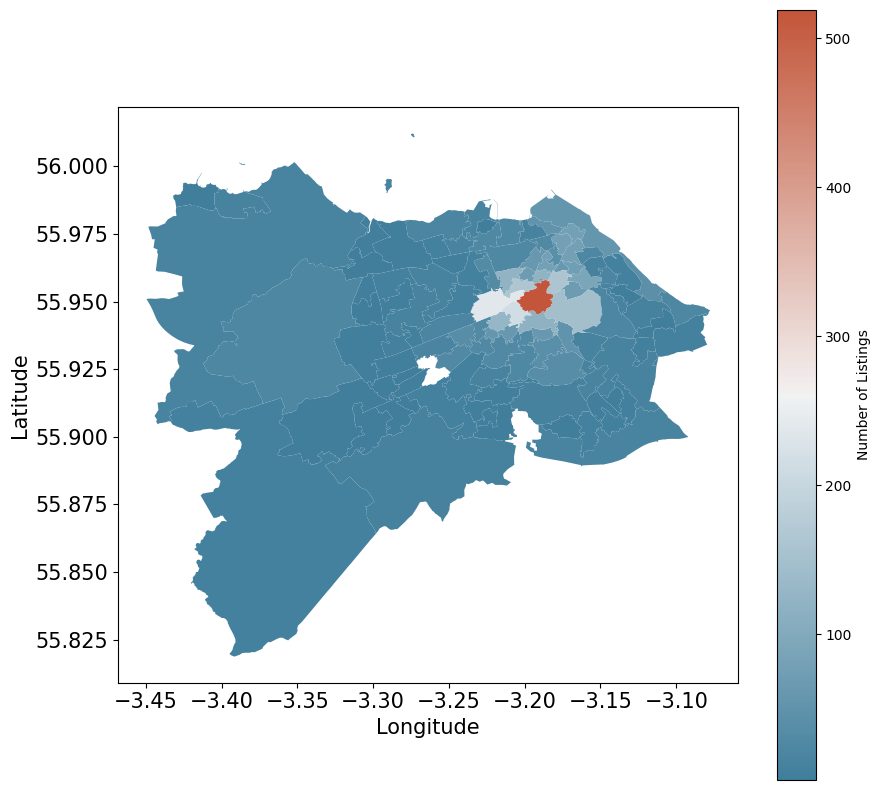

In [7]:
mapDF2 = dfDropped['neighbourhood_cleansed'].value_counts().reset_index()
mapDF2 = mapDF2.rename({"neighbourhood_cleansed":"neighbourhood count"}, axis='columns')
mapDF2 = mapDF2.rename({"index":"neighbourhood"}, axis='columns')
mapDF2 = neighbourhoodson.merge(mapDF2, on = 'neighbourhood', how = 'left')
mapDF2 = mapDF2.drop(['neighbourhood_group'], axis=1)
display(mapDF2.info())

cmap = sns.diverging_palette(230, 20, as_cmap=True)


ax = mapDF2.plot(column='neighbourhood count',  legend=True, figsize=(10, 10), cmap = cmap, legend_kwds = {"label": "Number of Listings"})

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

#adding x and y labels
plt.xlabel("Longitude", fontsize = 15)
plt.ylabel("Latitude" , fontsize = 15)



In [8]:
calendar = pd.read_csv("https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/calendar.csv.gz")
calendar.dropna(inplace=True)


calendar['price'] = calendar['price'].str.replace("$", "")
calendar['price'] = calendar['price'].str.replace(",", "")
calendar['price'] = calendar['price'].astype(float)

calendar['adjusted_price'] = calendar['adjusted_price'].str.replace("$", "")
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(",", "")
calendar['adjusted_price'] = calendar['adjusted_price'].astype(float)

calendar = calendar[calendar.price > 0]
calendar = calendar[calendar.adjusted_price > 0]
calendar.available = calendar.available.map({'t': 1, "f": 0})
calendar['date'] = pd.to_datetime(calendar['date'])

accomadates_df = dfDropped.copy(True) 
accomadates_df = accomadates_df[['id', 'accommodates']]
display(accomadates_df)
fringe_df = calendar[(calendar['date'] >= np.datetime64('2023-08-04')) & (calendar['date'] <= np.datetime64('2023-08-28'))]

# display(accomadates)

/var/folders/24/ng3jyr1s1xl2yrxrpzkc9tl80000gn/T/ipykernel_41959/196696678.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar['price'] = calendar['price'].str.replace("$", "")
/var/folders/24/ng3jyr1s1xl2yrxrpzkc9tl80000gn/T/ipykernel_41959/196696678.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar['adjusted_price'] = calendar['adjusted_price'].str.replace("$", "")


,id,accommodates
0,15420,2
2,728199,3
3,732008,10
4,744710,4
5,748646,6
...,...,...
7383,361050,2
7384,362653,2
7385,363642,2
7386,376937,6


In [9]:
fringe_df2 = fringe_df[['listing_id', 'price']]

fringe_df2 = fringe_df2.groupby('listing_id')['price'].mean().round(2).reset_index()

In [10]:
fringe_grouped = dfDropped.copy(True) 

fringe_grouped = fringe_grouped[['id', 'neighbourhood_cleansed']]
fringe_grouped = fringe_grouped.rename({"id":"listing_id"}, axis='columns')
fringe_grouped = fringe_grouped.rename({"neighbourhood_cleansed":"neighbourhood"}, axis='columns')

fringe_grouped2 = pd.merge(fringe_grouped, fringe_df2, on='listing_id')

display(fringe_grouped2.info())

fringe_grouped2 = fringe_grouped2.groupby(['neighbourhood'])['price'].mean().round(2).reset_index()

fringe_grouped2 = neighbourhoodson.merge(fringe_grouped2, on = 'neighbourhood', how = 'left')

display(fringe_grouped2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4167 entries, 0 to 4166
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   listing_id     4167 non-null   int64  
 1   neighbourhood  4167 non-null   object 
 2   price          4167 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 130.2+ KB


None

,neighbourhood,neighbourhood_group,geometry,price
0,Balerno and Bonnington Village,NaN,"MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...",169.18
1,Currie West,NaN,"MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...",99.55
2,Currie East,NaN,"MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...",70.05
3,Baberton and Juniper Green,NaN,"MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...",79.50
4,Bonaly and The Pentlands,NaN,"MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...",159.41
...,...,...,...,...
106,South Gyle,NaN,"MULTIPOLYGON (((-3.30084 55.94246, -3.30081 55...",171.38
107,"Ratho, Ingliston and Gogar",NaN,"MULTIPOLYGON (((-3.34287 55.96432, -3.34150 55...",162.84
108,Queensferry West,NaN,"MULTIPOLYGON (((-3.41600 55.99385, -3.41582 55...",110.69
109,"Dalmeny, Kirkliston and Newbridge",NaN,"MULTIPOLYGON (((-3.29012 55.99545, -3.28998 55...",140.96


Text(61.472222222222214, 0.5, 'Latitude')

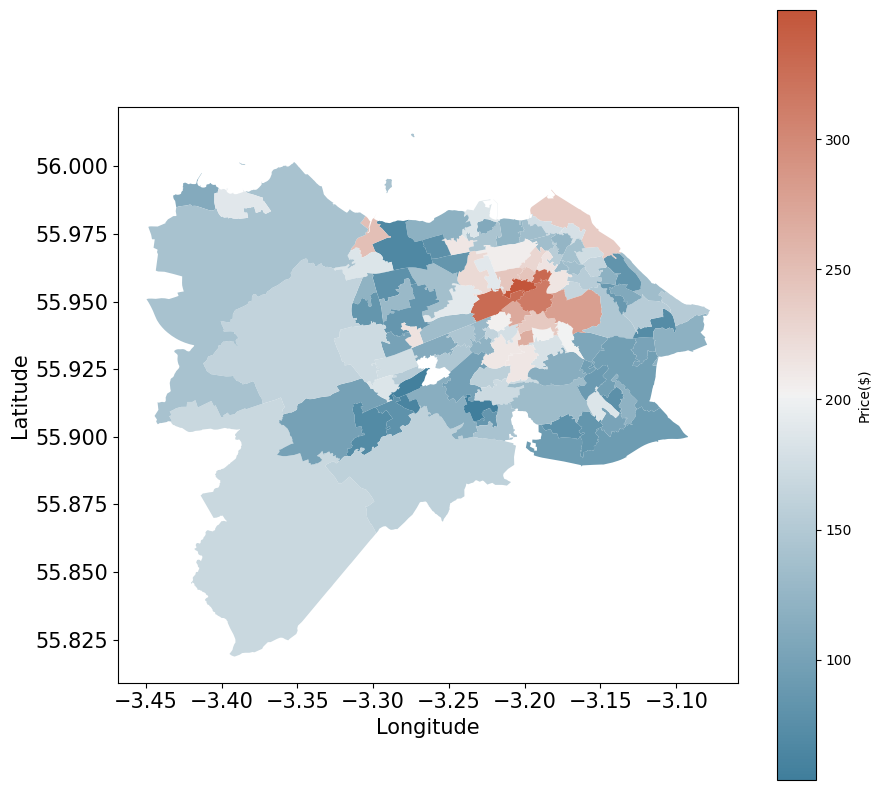

In [11]:
ax = fringe_grouped2.plot(column='price',  legend=True, figsize=(10, 10), cmap = cmap, legend_kwds = {"label": "Price($)"})

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

#adding x and y labels
plt.xlabel("Longitude", fontsize = 15)
plt.ylabel("Latitude" , fontsize = 15)

<h1>Creating bar graph to show number of active listings every 6 months since 2015<h1>

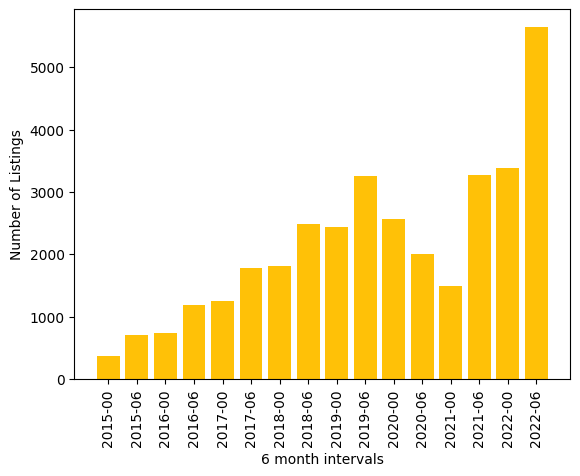

In [12]:
reviewDF = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/reviews.csv.gz')
reviewDF['date'] = pd.to_datetime(reviewDF['date'])

reviewDF2015 = reviewDF[(reviewDF['date'] >= np.datetime64('2015-01-01')) & (reviewDF['date'] <= np.datetime64('2015-05-31'))]
reviewDF20152 = reviewDF[(reviewDF['date'] >= np.datetime64('2015-06-01')) & (reviewDF['date'] <= np.datetime64('2015-12-31'))]
reviewDF2016 = reviewDF[(reviewDF['date'] >= np.datetime64('2016-01-01')) & (reviewDF['date'] <= np.datetime64('2016-05-31'))]
reviewDF20162 = reviewDF[(reviewDF['date'] >= np.datetime64('2016-06-01')) & (reviewDF['date'] <= np.datetime64('2016-12-31'))]
reviewDF2017 = reviewDF[(reviewDF['date'] >= np.datetime64('2017-01-01')) & (reviewDF['date'] <= np.datetime64('2017-05-31'))]
reviewDF20172 = reviewDF[(reviewDF['date'] >= np.datetime64('2017-06-01')) & (reviewDF['date'] <= np.datetime64('2017-12-31'))]
reviewDF2018 = reviewDF[(reviewDF['date'] >= np.datetime64('2018-01-01')) & (reviewDF['date'] <= np.datetime64('2018-05-31'))]
reviewDF20182 = reviewDF[(reviewDF['date'] >= np.datetime64('2018-06-01')) & (reviewDF['date'] <= np.datetime64('2018-12-31'))]
reviewDF2019 = reviewDF[(reviewDF['date'] >= np.datetime64('2019-01-01')) & (reviewDF['date'] <= np.datetime64('2019-05-31'))]
reviewDF20192 = reviewDF[(reviewDF['date'] >= np.datetime64('2019-06-01')) & (reviewDF['date'] <= np.datetime64('2019-12-31'))]
reviewDF2020 = reviewDF[(reviewDF['date'] >= np.datetime64('2020-01-01')) & (reviewDF['date'] <= np.datetime64('2020-05-31'))]
reviewDF20202 = reviewDF[(reviewDF['date'] >= np.datetime64('2020-06-01')) & (reviewDF['date'] <= np.datetime64('2020-12-31'))]
reviewDF2021 = reviewDF[(reviewDF['date'] >= np.datetime64('2021-01-01')) & (reviewDF['date'] <= np.datetime64('2021-05-31'))]
reviewDF20212 = reviewDF[(reviewDF['date'] >= np.datetime64('2021-06-01')) & (reviewDF['date'] <= np.datetime64('2021-12-31'))]
reviewDF2022 = reviewDF[(reviewDF['date'] >= np.datetime64('2022-01-01')) & (reviewDF['date'] <= np.datetime64('2022-05-31'))]
reviewDF20222 = reviewDF[(reviewDF['date'] >= np.datetime64('2022-06-01')) & (reviewDF['date'] <= np.datetime64('2022-12-31'))]
reviewDF2023 = reviewDF[(reviewDF['date'] >= np.datetime64('2023-01-01')) & (reviewDF['date'] <= np.datetime64('2023-05-31'))]
reviewDF20232 = reviewDF[(reviewDF['date'] >= np.datetime64('2023-06-01')) & (reviewDF['date'] <= np.datetime64('2023-12-31'))]

reviewDF2015 = reviewDF2015['listing_id'].nunique()
reviewDF20152 = reviewDF20152['listing_id'].nunique()
reviewDF2016 = reviewDF2016['listing_id'].nunique()
reviewDF20162 = reviewDF20162['listing_id'].nunique()
reviewDF2017 = reviewDF2017['listing_id'].nunique()
reviewDF20172 = reviewDF20172['listing_id'].nunique()
reviewDF2018 = reviewDF2018['listing_id'].nunique()
reviewDF20182 = reviewDF20182['listing_id'].nunique()
reviewDF2019 = reviewDF2019['listing_id'].nunique()
reviewDF20192 = reviewDF20192['listing_id'].nunique()
reviewDF2020 = reviewDF2020['listing_id'].nunique()
reviewDF20202 = reviewDF20202['listing_id'].nunique()
reviewDF2021 = reviewDF2021['listing_id'].nunique()
reviewDF20212 = reviewDF20212['listing_id'].nunique()
reviewDF2022 = reviewDF2022['listing_id'].nunique()
reviewDF20222 = reviewDF20222['listing_id'].nunique()

height = [reviewDF2015, reviewDF20152, reviewDF2016, reviewDF20162, reviewDF2017, reviewDF20172, reviewDF2018, reviewDF20182, reviewDF2019, reviewDF20192, reviewDF2020, reviewDF20202, reviewDF2021, reviewDF20212, reviewDF2022, reviewDF20222]
bars = ('2015-00', '2015-06', '2016-00', '2016-06', '2017-00', '2017-06', '2018-00', '2018-06', '2019-00', '2019-06', '2020-00', '2020-06', '2021-00', '2021-06', '2022-00', '2022-06')
x_pos = np.arange(len(bars))
 
plt.bar(x_pos, height, color = '#ffc107')

plt.xlabel('6 month intervals')
plt.ylabel('Number of Listings')
 
plt.xticks(x_pos, bars, rotation = 'vertical')
 
plt.show()